In [1]:
!poetry install

Installing dependencies from lock file

Package operations: 0 installs, 1 update, 0 removals

  - Updating numpy (2.0.2 -> 2.1.3): Pending...
  - Updating numpy (2.0.2 -> 2.1.3): Failed

  OSError

  [Errno 101] Network is unreachable

  at ~/ml-for-science-aith24/.venv/lib/python3.10/site-packages/urllib3/util/connection.py:73 in create_connection
       69│             if timeout is not _DEFAULT_TIMEOUT:
       70│                 sock.settimeout(timeout)
       71│             if source_address:
       72│                 sock.bind(source_address)
    →  73│             sock.connect(sa)
       74│             # Break explicitly a reference cycle
       75│             err = None
       76│             return sock
       77│ 

The following error occurred when trying to handle this error:


  NewConnectionError

  <urllib3.connection.HTTPSConnection object at 0x7f8c3113b5b0>: Failed to establish a new connection: [Errno 101] Network is unreachable

  at ~/ml-for-science-aith24/.venv/

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score
import xgboost as xgb
import optuna
from sklearn.model_selection import cross_val_score
import joblib
from imblearn.combine import SMOTEENN
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import shap

/home/erofdmit/ml-for-science-aith24/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Загрузка данных
path = os.path.join('..', 'hotel_reservations.csv')
df = pd.read_csv(path)

# Выбранные переменные
selected_columns = [
    'no_of_children',
    'no_of_weekend_nights',
    'no_of_week_nights',
    'arrival_month',
    'market_segment_type',
    'repeated_guest',
    'required_car_parking_space',
    'booking_status'  # Целевая переменная
]
df = df[selected_columns]

# Кодирование целевой переменной booking_status
df['booking_status'] = df['booking_status'].map({'Canceled': 0, 'Not_Canceled': 1})
if df['booking_status'].isnull().any():
    raise ValueError("Найдены пропущенные значения в 'booking_status' после кодирования!")

# Кодирование бинарных переменных
df['repeated_guest'] = df['repeated_guest'].astype(int)
df['required_car_parking_space'] = df['required_car_parking_space'].astype(int)

# Кодирование многоклассовой переменной market_segment_type
ohe = OneHotEncoder(sparse_output=False, drop='first')
market_segment_encoded = ohe.fit_transform(df[['market_segment_type']])

market_segment_df = pd.DataFrame(
    market_segment_encoded,
    columns=[f"market_segment_{cat}" for cat in ohe.categories_[0][1:]],
    index=df.index  # Сохраняем индексы для корректного объединения
)

# Обновляем df: удаляем старую переменную и добавляем закодированные столбцы
df = pd.concat([df.drop('market_segment_type', axis=1), market_segment_df], axis=1)

# Целевая переменная и признаки
X = df.drop(columns=['booking_status'])  # Признаки
y = df['booking_status']  # Целевая переменная


# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,  # Размер тестового набора
    random_state=42,  # Фиксируем seed для воспроизводимости
    stratify=y  # Сохраняем пропорции классов
)

# Проверка результата
print(f"Размеры данных: X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")
print("\nОбработанный датафрейм (первые строки):")
print(df.head())

Размеры данных: X_train: (29020, 10), X_test: (7255, 10), y_train: (29020,), y_test: (7255,)

Обработанный датафрейм (первые строки):
   no_of_children  no_of_weekend_nights  no_of_week_nights  arrival_month  \
0               0                     1                  2             10   
1               0                     2                  3             11   
2               0                     2                  1              2   
3               0                     0                  2              5   
4               0                     1                  1              4   

   repeated_guest  required_car_parking_space  booking_status  \
0               0                           0               1   
1               0                           0               1   
2               0                           0               0   
3               0                           0               0   
4               0                           0               0   

   market_se

Все что выше - дублировано из HW2. Далее приступим к HW3


Добавим еще один этап обработки - сбалансируем классы, тем самым попытаемся устранить тонкое место, найденное в предыдущем Дз.


In [4]:
smoteenn = SMOTEENN(random_state=42)
X_train_balanced, y_train_balanced = smoteenn.fit_resample(X_train, y_train)

Почему выбран градиентный бустинг?
Градиентный бустинг, в частности XGBoost, был выбран по следующим причинам:

- Эффективность на табличных данных: XGBoost отлично справляется с задачами классификации на табличных наборах данных благодаря своей архитектуре и поддержке работы с несбалансированными классами.
- Обработка дисбаланса классов: XGBoost предоставляет встроенные механизмы для работы с дисбалансом классов, такие как параметр scale_pos_weight, что делает его удобным для задач с доминирующими классами.

In [5]:
xgb_clf = xgb.XGBClassifier(
    tree_method='hist',  
    device='cuda',       # Использование GPU
    random_state=42,     # Фиксируем seed для воспроизводимости
    eval_metric='logloss')

## Оптимизируемые гиперпараметры и причины их выбора

| **Параметр**         | **Описание**                                                                                   | **Причина оптимизации**                                                                                   |
|-----------------------|-----------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------|
| **`n_estimators`**    | Количество деревьев в ансамбле.                                                               | Слишком малое значение может привести к недообучению, а слишком большое — к переобучению.                 |
| **`max_depth`**       | Максимальная глубина деревьев.                                                               | Контролирует сложность деревьев: слишком большие значения могут привести к переобучению.                  |
| **`learning_rate`**   | Скорость обучения.                                                                            | Контролирует размер шага градиентного обновления. Низкие значения повышают стабильность, но увеличивают время обучения. |
| **`subsample`**       | Доля объектов, используемая для обучения каждого дерева.                                      | Уменьшение этого параметра помогает предотвратить переобучение, но слишком низкие значения могут ухудшить качество. |
| **`colsample_bytree`**| Доля признаков, используемых для построения каждого дерева.                                   | Уменьшение снижает вероятность переобучения, повышая устойчивость к шуму.                                |
| **`gamma`**           | Минимальный прирост метрики качества, необходимый для разделения узла.                       | Регуляризатор, помогающий уменьшить переобучение.                                                         |
| **`scale_pos_weight`**| Вес для компенсации дисбаланса классов.  

In [6]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

Подбор гиперпараметров через scikit-learn

In [7]:
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,  
    verbose=1
)

In [8]:
# Обучение модели с подбором гиперпараметров
grid_search.fit(X_train_balanced, y_train_balanced)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


/home/erofdmit/ml-for-science-aith24/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:43:42] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device='cuda',
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rat...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [50, 100], 'subsample': [0.8, 1.0]},
             scoring='f1_macro', verbose=1)

In [9]:
# Вывод лучших гиперпараметров
print(f"Лучшие параметры: {grid_search.best_params_}")

# Извлечение обученной модели с лучшими параметрами
best_model = grid_search.best_estimator_

Лучшие параметры: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


Подбор гиперпараметров через Optuna

In [10]:
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "tree_method": "hist",
        "predictor": "gpu_predictor",
        "random_state": 42,
        "device": "cuda"
    }    
    # Модель
    model = xgb.XGBClassifier(**param)

    # Кросс-валидация
    scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=3, scoring="f1_macro", n_jobs=-1)
    return scores.mean()

In [11]:
# Создаем исследование
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)


print("Лучшие параметры:", study.best_params)


[I 2024-11-29 00:44:26,935] A new study created in memory with name: no-name-5f10aa52-76a1-49fa-8842-eb0ec2112bb4
/home/erofdmit/ml-for-science-aith24/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:44:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/home/erofdmit/ml-for-science-aith24/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:44:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/home/erofdmit/ml-for-science-aith24/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:44:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/home/erofdmit/ml-for-science-aith24/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:44:30] WARNING: /workspace/src/common/error_msg.cc:58: Falling back 

Лучшие параметры: {'n_estimators': 396, 'max_depth': 12, 'learning_rate': 0.2790966227411927, 'subsample': 0.5749465245865607, 'colsample_bytree': 0.9656047724824356, 'gamma': 0.33682026028269285}


In [12]:
best_params_opt = study.best_params

Сравнение гиперпараметров

# Целевая метрика

В качестве целевой метрики была выбрана **`F1 (macro)`**, поскольку:

- **Учитывает оба класса одинаково**: Эта метрика важна в задачах с дисбалансом классов, так как точность (accuracy) может быть смещена в пользу доминирующего класса.
- **Баланс между Precision и Recall**: F1-score является гармоническим средним между Precision и Recall, что делает её более сбалансированной для оценки качества модели.

In [13]:
# GridSearchCV
y_test_pred_grid = grid_search.best_estimator_.predict(X_test)
f1_macro_grid = f1_score(y_test, y_test_pred_grid, average='macro')
print(f"F1 (macro) для GridSearchCV: {f1_macro_grid:.3f}")

# Optuna
y_test_pred_optuna = best_model.predict(X_test)
f1_macro_optuna = f1_score(y_test, y_test_pred_optuna, average='macro')
print(f"F1 (macro) для Optuna: {f1_macro_optuna:.3f}")

F1 (macro) для GridSearchCV: 0.553
F1 (macro) для Optuna: 0.553


Тем не менее будем испольовать Optuna, так как ее гиперпараметры более точные

In [14]:
best_params_opt['scale_pos_weight'] = len(y_train[y_train == 1]) / len(y_train[y_train == 0])


In [15]:
best_model = xgb.XGBClassifier(**best_params_opt)
best_model.fit(X_train_balanced, y_train_balanced)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9656047724824356, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.33682026028269285,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2790966227411927,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=396, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Предсказания на тестовом наборе

In [16]:
y_test_pred = best_model.predict(X_test)

Измерение качества на тестовом наборе

In [17]:
print("\nОценка качества на отложенной выборке:")
print(classification_report(y_test, y_test_pred))


Оценка качества на отложенной выборке:
              precision    recall  f1-score   support

           0       0.46      0.37      0.41      2377
           1       0.72      0.79      0.75      4878

    accuracy                           0.65      7255
   macro avg       0.59      0.58      0.58      7255
weighted avg       0.63      0.65      0.64      7255



### Интерпретация модели

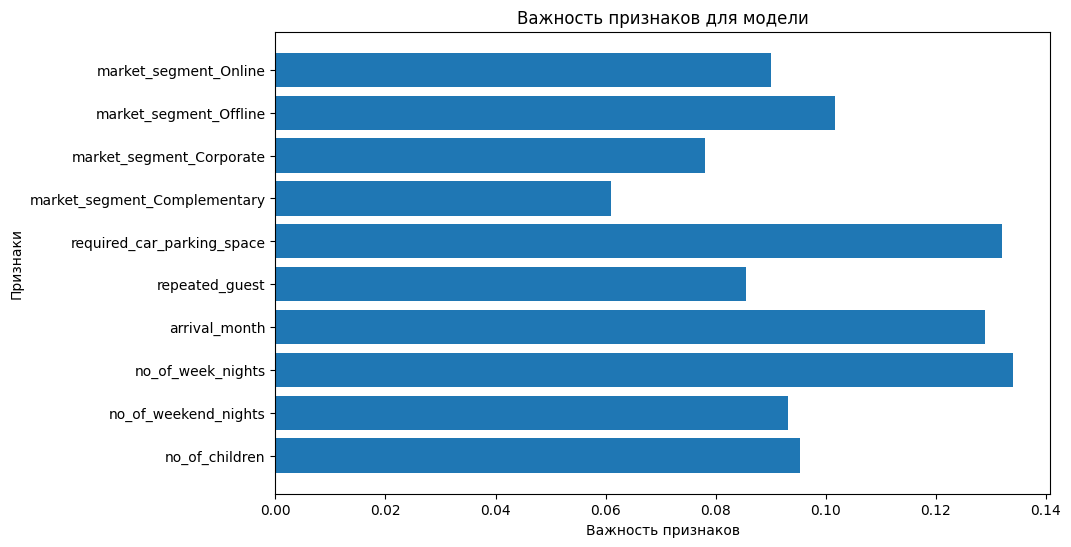

In [18]:
# Важность признаков
feature_importances = best_model.feature_importances_

# Построение графика
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, feature_importances)
plt.xlabel("Важность признаков")
plt.ylabel("Признаки")
plt.title("Важность признаков для модели")
plt.show()

#### Ключевые наблюдения:

1. **Наиболее важные признаки**:
   - **`required_car_parking_space`**: Этот признак имеет наибольшую важность, что может указывать на то, что запрос парковочного места тесно связан с вероятностью отмены бронирования. Возможно, клиенты, которые не запрашивают парковку, чаще отменяют свои заказы (например, путешественники без машины).
   - **`no_of_week_nights`**: Количество ночей в будние дни также играет ключевую роль. Это может быть связано с тем, что долгосрочные или рабочие поездки имеют меньшую вероятность отмены.
   - **`no_of_weekend_nights`**: Ночи на выходных также оказывают значительное влияние, возможно, из-за разницы в типе бронирований (семейные поездки, короткие поездки на выходные).

2. **Умеренно важные признаки**:
   - **`market_segment_Offline`** и **`market_segment_Online`**: Способ бронирования (онлайн или оффлайн) имеет умеренную важность. Например, клиенты, бронирующие через оффлайн-каналы (агентства), могут реже отменять.
   - **`arrival_month`**: Месяц прибытия также влияет на вероятность отмены. Это может быть связано с сезонными изменениями спроса, например, высоким спросом летом или в праздничные периоды.

3. **Менее важные признаки**:
   - **`repeated_guest`**: Постоянные клиенты имеют меньший вес в модели. Это логично, так как их поведение более предсказуемо, и они, скорее всего, реже отменяют бронирования.
   - **`no_of_children`**: Количество детей также оказывает меньший эффект, возможно, из-за небольшой вариативности данных (мало бронирований с детьми).

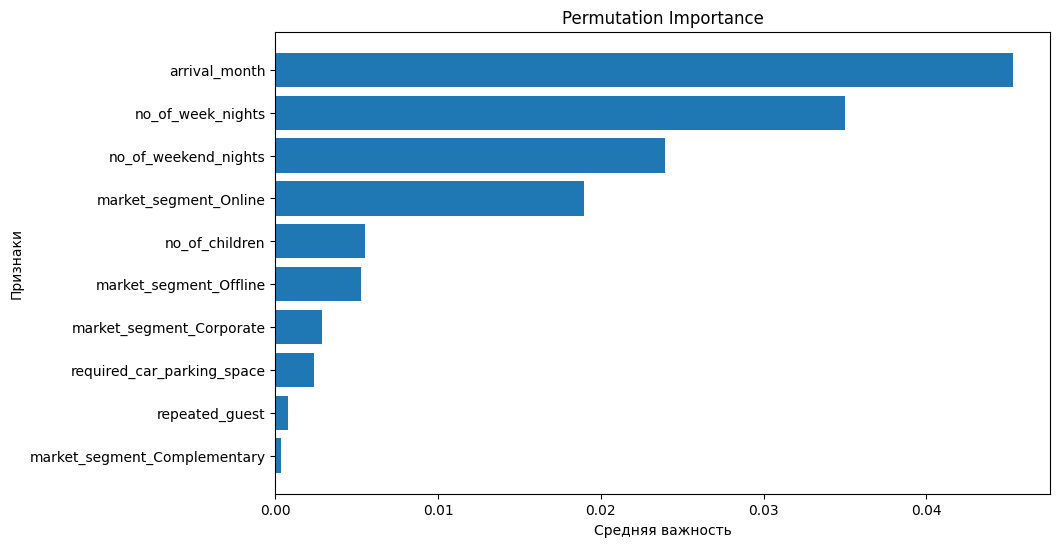

In [19]:
# Permutation Importance
perm_importance = permutation_importance(best_model, X_test, y_test, scoring='f1_macro')

# Визуализация
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Средняя важность")
plt.ylabel("Признаки")
plt.title("Permutation Importance")
plt.show()

#### Ключевые наблюдения:

1. **Наиболее важные признаки**:
   - **`arrival_month`**: Месяц прибытия оказывает наибольшее влияние на предсказания модели. Это логично, так как отмены бронирований могут зависеть от сезонности и специфики высокого/низкого сезонов.
   - **`no_of_week_nights`**: Количество ночей в будние дни является вторым по значимости. Это связано с тем, что бизнес- или рабочие поездки, как правило, реже отменяются.
   - **`no_of_weekend_nights`**: Ночи на выходных также имеют существенное влияние. Возможно, короткие поездки на выходные имеют характерный паттерн поведения, связанный с отменами.

2. **Умеренно важные признаки**:
   - **`market_segment_Online`**: Тип бронирования (онлайн) оказывает влияние на модель. Это может объясняться разницей в поведении пользователей разных каналов бронирования.
   - **`no_of_children`**: Количество детей имеет среднюю значимость. Клиенты с детьми, вероятно, принимают решения о бронировании с большей осмотрительностью.

3. **Менее важные признаки**:
   - **`market_segment_Offline`** и **`market_segment_Corporate`**: Эти каналы бронирования имеют меньшую важность, но всё же дают модели полезную информацию.
   - **`required_car_parking_space`**: Хотя в feature importance этот признак был одним из ведущих, здесь он имеет низкую значимость. Это указывает на возможную корреляцию с другими признаками, такими как тип бронирования или поведение клиентов.
   - **`repeated_guest`**: Постоянные клиенты вносят минимальный вклад в модель, что может быть связано с тем, что их поведение предсказуемо и редко меняется.

100%|===================| 7228/7255 [01:00<00:00]        

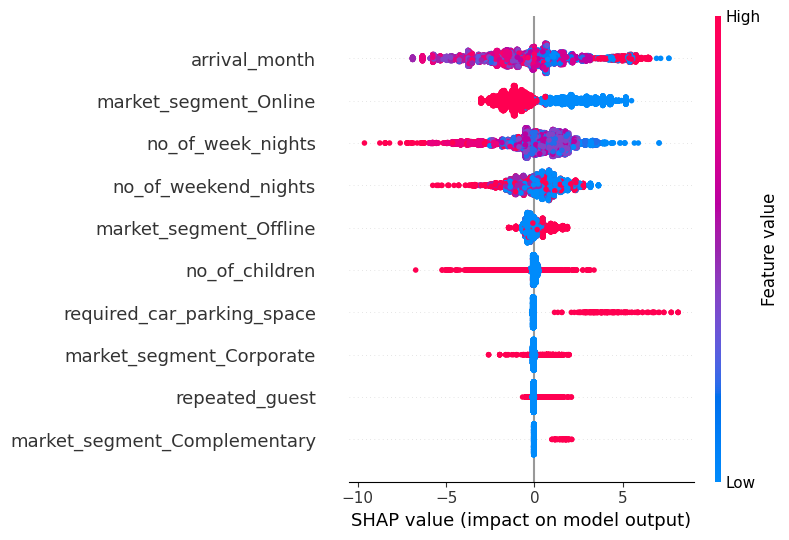

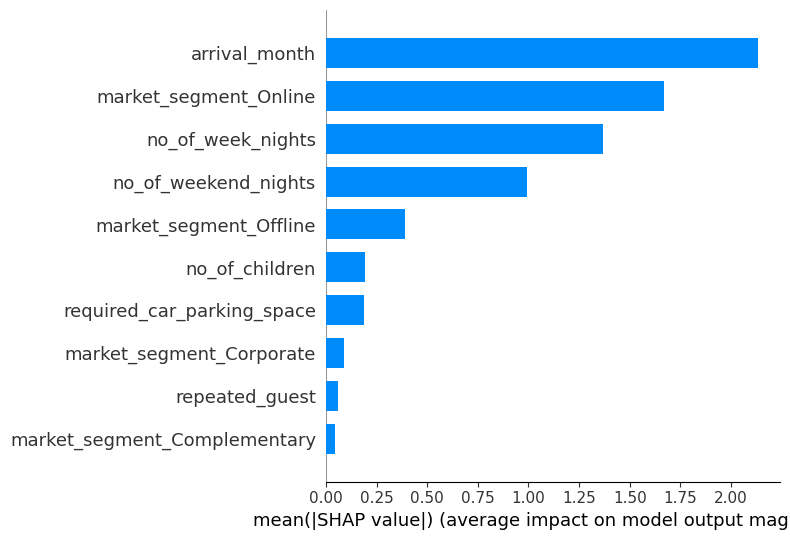

In [20]:
# Создание объекта SHAP для XGBoost
explainer = shap.Explainer(best_model, X_train)

# Вычисление SHAP-значений
shap_values = explainer(X_test)

# Визуализация общих характеристик модели
shap.summary_plot(shap_values, X_test)

# Визуализация важности отдельных признаков
shap.summary_plot(shap_values, X_test, plot_type="bar")

#### График 1: Ключевые наблюдения:

1. **Наиболее значимые признаки**:
   - **`arrival_month`**:
     - Высокие значения (поздние месяцы) оказывают сильное положительное влияние на вероятность отмены бронирования.
     - Низкие значения (ранние месяцы) уменьшают вероятность отмены.
   - **`market_segment_Online`**:
     - Высокие значения (принадлежность к онлайн-каналу) увеличивают вероятность отмены.
     - Низкие значения (отсутствие принадлежности к онлайн-каналу) снижают вероятность отмены.
   - **`no_of_week_nights`** и **`no_of_weekend_nights`**:
     - Чем больше ночей в будние и выходные, тем ниже вероятность отмены бронирования.

2. **Менее значимые признаки**:
   - **`required_car_parking_space`**:
     - Наличие запроса парковочного места (высокие значения) снижает вероятность отмены бронирования.
   - **`market_segment_Offline`**:
     - Бронирования через оффлайн-каналы уменьшают вероятность отмены, что логично, так как эти клиенты могут быть более предсказуемы.
   - **`no_of_children`**:
     - Высокие значения (наличие детей) оказывают минимальное влияние на вероятность отмены, но с небольшим увеличением в сторону сохранения бронирования.

3. **Редко используемые признаки**:
   - **`repeated_guest`** и **`market_segment_Complementary`**:
     - Оказывают минимальное влияние на предсказания. Постоянные клиенты и комплементарные сегменты менее вариативны в своём поведении.

#### График 2: Ключевые наблюдения:

1. **Наиболее значимые признаки**:
   - **`arrival_month`**:
     - Этот признак оказывает наибольшее влияние на предсказания. Это указывает на то, что сезонность сильно влияет на вероятность отмены бронирования. Например, бронирования в "пиковые" месяцы могут чаще подтверждаться, тогда как в низкий сезон клиенты могут чаще отменять.
   - **`market_segment_Online`**:
     - Тип канала бронирования (онлайн) занимает второе место по важности. Клиенты, бронирующие через онлайн-каналы, могут иметь более высокий уровень отмен.
   - **`no_of_week_nights`** и **`no_of_weekend_nights`**:
     - Длительность пребывания играет ключевую роль. Длительные поездки, особенно на будние дни, чаще связаны с низкой вероятностью отмен.

2. **Умеренно важные признаки**:
   - **`market_segment_Offline`**:
     - Оффлайн-каналы бронирования имеют меньшую значимость, но всё же оказывают влияние. Возможно, клиенты из оффлайн-каналов (например, через агентства) чаще придерживаются своих бронирований.
   - **`no_of_children`**:
     - Наличие детей оказывает небольшое влияние на предсказания, но может отражать более серьёзные намерения клиентов.

3. **Менее важные признаки**:
   - **`required_car_parking_space`**:
     - Запрос парковки имеет относительно низкую значимость, хотя ранее считался важным. Это может быть связано с сильной корреляцией с другими признаками.
   - **`market_segment_Corporate`** и **`repeated_guest`**:
     - Эти признаки вносят минимальный вклад. Постоянные клиенты и корпоративные бронирования, как правило, имеют более стабильное поведение.
